
*  **Name: AmirHossein Mohammadi**
*  **Std number: 99201081**


# Import Library

In [10]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import utils
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from torch.nn import Conv2d 
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Upsample


## Download Dataset


In [78]:
from zipfile import ZipFile
import os
import numpy as np
import gdown

output = 'images.npy.zip'
url= "https://drive.google.com/u/0/uc?id=1gRylgMQbsdMjdYePhV-03z0VVlfcd21v&export=download"
gdown.download(url, output, quiet=True)
output = 'masks.npy.zip'
url= "https://drive.google.com/u/0/uc?id=1-1NzrnJ1VJ3c9ngSMmGd1qAO9rHuSNZe&export=download"
gdown.download(url, output, quiet=True)


'masks.npy.zip'

## Unzip and Make dir

In [79]:
with ZipFile('content/images_npy.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('\content')

with ZipFile('content/masks_npy.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('\content')

os.remove('images.npy.zip')
os.remove('masks.npy.zip')
DIR_PATH = "\content"
X_FILE = "\images_medseg.npy"
Y_FILE = "\masks_medseg.npy"

imgs = np.load(DIR_PATH+X_FILE).astype(np.float32)
msks = np.load(DIR_PATH+Y_FILE).astype(np.float32)

## Visualise the Images

In [97]:
import matplotlib.pyplot as plt


plt.style.use("dark_background")

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    #print(j)
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

***Description***


*   Actual Input
*   Mask for Ground Glass class
*   Mask for Consolidation class
*   Mask for Background Class

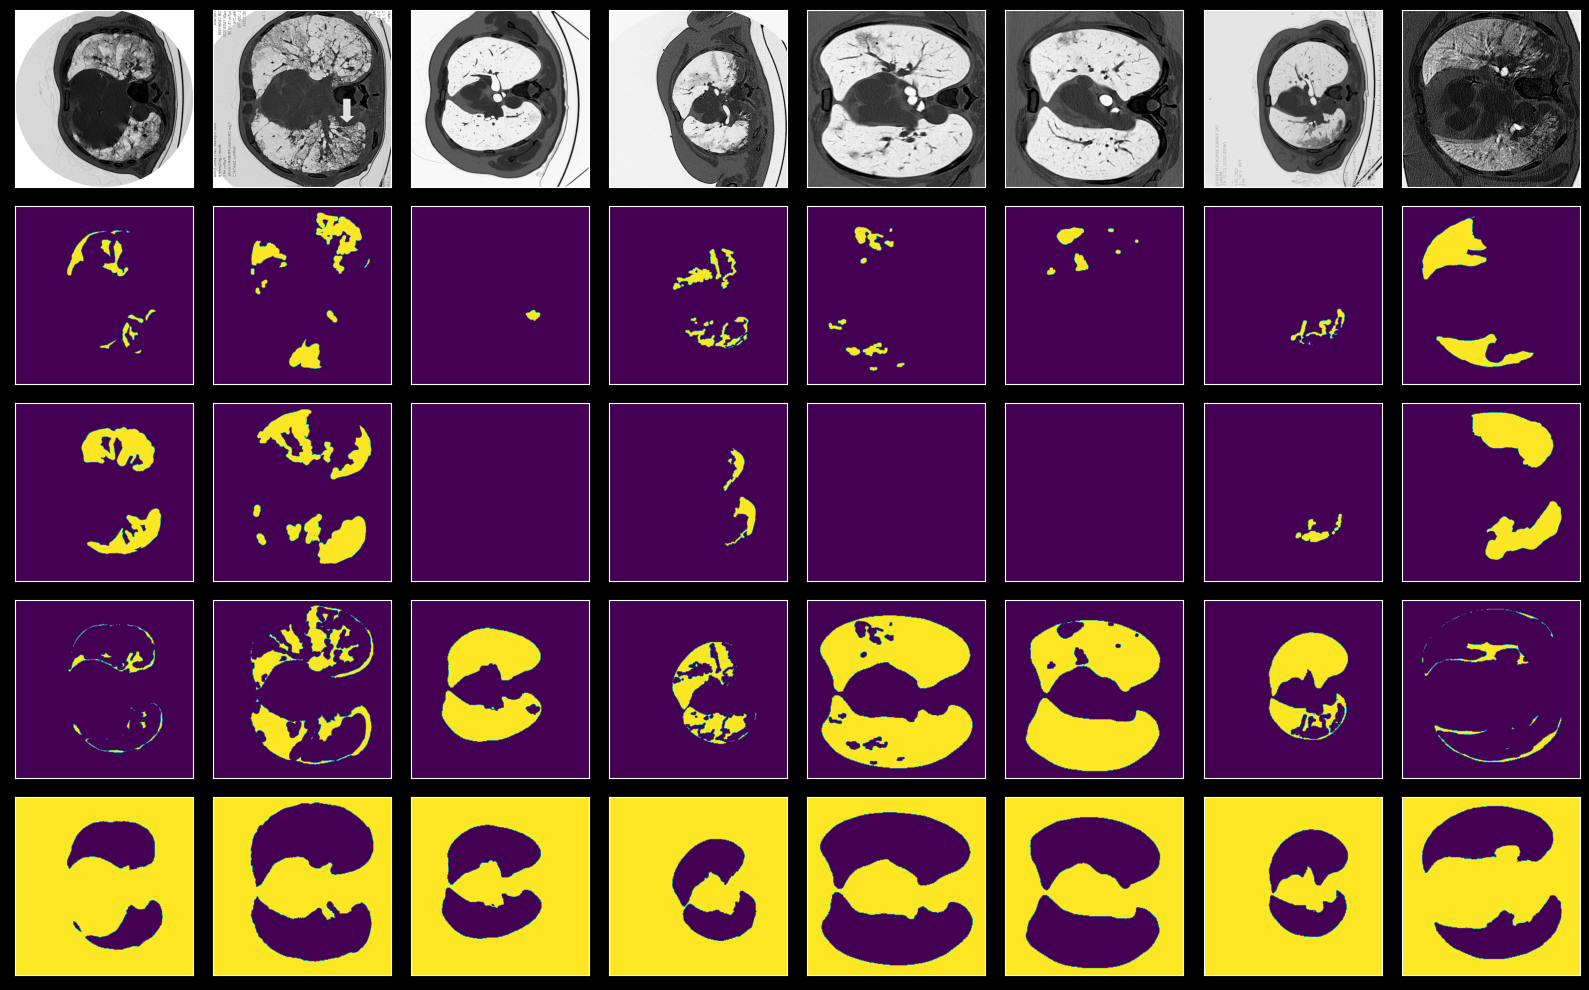

In [98]:
visualize(imgs, msks)

# Create Dataset and use one Mask

In [99]:
import torch

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x, labels):
        'Initialization'
        self.labels = labels
        self.x = x

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        x = self.x[index]
        y = self.labels[index]

        return x, y
dataset = Dataset(imgs.reshape((100,1,512,512)), msks[:,:,:,3].reshape((100,1,512,512)))

## Splite Dataset

In [100]:
# 0.1 for test
from torch.utils.data import random_split
tst_size = int(np.ceil(dataset.__len__()*0.1))
train_size = dataset.__len__()- tst_size 
train_data,test_data = random_split(dataset,[train_size,tst_size])

## DataLoaders

In [101]:
# batchsize < 5
from torch.utils.data import DataLoader,TensorDataset
batch_size=4
train_dataloader = DataLoader(train_data,batch_size = batch_size,shuffle=True)
val_dataloader = DataLoader(test_data,batch_size = batch_size,shuffle=True)

## Unet


In [102]:
class Up(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Up, self).__init__()
        ###########################################
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv_layers= nn.Sequential(
            Conv2d(
                  channel_in,
                   channel_out,
                   kernel_size=3,
                   padding=1),
                   nn.BatchNorm2d(channel_out),
                   nn.ReLU(),
            Conv2d(
                  channel_out,
                   channel_out,
                   kernel_size=3,
                   padding=1),
                   nn.BatchNorm2d(channel_out),
                   nn.ReLU()
        )
        ###########################################

    def forward(self, output1, output2):
        ###########################################
        output1 = self.upsample(output1)
        X_minus = output1.size()[2] - output2.size()[2]
        Y_minus = output1.size()[3] - output2.size()[3]
        output2 = F.pad(output2, (X_minus // 2, int(X_minus / 2),
                        Y_minus // 2, int(Y_minus / 2)))
        final_output = torch.cat([output2, output1], dim=1)
        final_output = self.conv_layers(final_output)
        return final_output        
        ###########################################
        
class Down(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Down, self).__init__()
        ###########################################
        self.conv_layers = nn.Sequential(
            Conv2d(
                channel_in,
                channel_out,
                kernel_size = 3,
                padding = 1),
                nn.BatchNorm2d(channel_out),
                nn.ReLU(),
            Conv2d(
                channel_out,
                channel_out,
                kernel_size = 3,
                padding = 1),
                nn.BatchNorm2d(channel_out),
                nn.ReLU()
        )
        ###########################################

    def forward(self, x):
        ###########################################
        x = self.conv_layers(F.max_pool2d(x,2))
        return x
        ###########################################

class UNet(nn.Module):
    def __init__(self, channel_in, classes):
        super(UNet, self).__init__()
        ###########################################
        self.conv1 = nn.Sequential(
            Conv2d(channel_in, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.down1 = Down(8, 16)
        self.down2 = Down(16, 32)
        self.down3 = Down(32, 32)
        self.up1 = Up(64, 16)
        self.up2 = Up(32, 8)
        self.up3 = Up(16, 4)
        self.conv2 = nn.Conv2d(4, classes, kernel_size = 1)
        ###########################################


    def forward(self, x):
        ###########################################
        output1 = self.conv1(x)
        output2 = self.down1(output1)
        x3 = self.down2(output2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, output2)
        x = self.up3(x, output1)
        x = self.conv2(x)
        x = F.sigmoid(x)
        return x
        ###########################################

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_uniform(m.weight, gain=numpy.sqrt(2.0))
        init.constant(m.bias, 0.1)

## IoU

In [103]:
treshhold=0.5
smooth_param = 1e-7
def IoU(output, target):
    oss = output > treshhold
    tss = target > treshhold
    inter = (oss & tss).sum(axis=[1, 2, 3])
    U = (oss | tss).sum(axis=[1, 2, 3])
    iou = ((inter + smooth_param) / (U + smooth_param)).mean()
    return iou

## Train and Test

In [104]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dev

device(type='cpu')

## Model Architecture

In [105]:
model = UNet(1, 1)
model.to(dev)
model

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (down1): Down(
    (conv_layers): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down2): Down(
    (conv_layers): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1

## Define Optimizer and Loss function

In [106]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.BCELoss()

## Define Training & Test function

In [107]:
def train(model, epoch):
    print ("***************Epoch Number "+str(epoch)+" is started***************")
    model.train()
    tr_loss=0.0
    correct = 0
    temp=0
    for data,target in train_dataloader:
        data, target = data.to(dev),target.to(dev)
        target = (target-torch.min(target))/(torch.max(target)-torch.min(target))
        optimizer.zero_grad()
        output = model.forward(data.float())
        loss = criterion(output.float(), target.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("Epoch Number {"+str(epoch)+"}:")
        print("Loss: "+str(float(loss.data)))
        tr_loss=tr_loss+float(loss.data)
        temp=temp+1
    train_loss.append(tr_loss/temp)      
            
            

def test(model):
    model.eval()
    loss = iou = 0.
    for data,target in val_dataloader:
        data, target = data.to(dev),target.to(dev)
        output = model(data.float())
        target = (target-torch.min(target))/(torch.max(target)-torch.min(target))
        loss += criterion(output.float(), target.float()).data 
        iou += IoU(output, target)   
    loss /= len(val_dataloader)
    test_loss.append(float(loss))
    iou /= len(val_dataloader)
    iou_param.append(float(iou))
    print("Test Loss:")
    print(float(loss))
    print("IOU metric:")
    print(float(iou))
    
def plot_func(loss,status,epch):
        plt.style.use("default")
        plt.title(status)
        plt.plot(range(1, epch+1), loss)
        plt.ylabel(status)
        plt.xlabel('Epochs')
        plt.show()


# Training Phase

In [108]:
train_loss=[]
test_loss=[]
iou_param=[]
Epoch = 15

for i in range(1, Epoch):
    train(model, i)
    test(model)

***************Epoch Number 1 is started***************
Epoch Number {1}:
Loss: 0.6300066113471985
Epoch Number {1}:
Loss: 0.6357618570327759
Epoch Number {1}:
Loss: 0.5329506397247314
Epoch Number {1}:
Loss: 0.5488003492355347
Epoch Number {1}:
Loss: 0.5131747126579285
Epoch Number {1}:
Loss: 0.5027629137039185
Epoch Number {1}:
Loss: 0.5037198066711426
Epoch Number {1}:
Loss: 0.4604625105857849
Epoch Number {1}:
Loss: 0.4417729377746582
Epoch Number {1}:
Loss: 0.4516691565513611
Epoch Number {1}:
Loss: 0.4443768262863159
Epoch Number {1}:
Loss: 0.44570404291152954
Epoch Number {1}:
Loss: 0.3996814787387848
Epoch Number {1}:
Loss: 0.4955331087112427
Epoch Number {1}:
Loss: 0.3995145559310913
Epoch Number {1}:
Loss: 0.41494232416152954
Epoch Number {1}:
Loss: 0.38675862550735474
Epoch Number {1}:
Loss: 0.4105179011821747
Epoch Number {1}:
Loss: 0.3866013288497925
Epoch Number {1}:
Loss: 0.3819049000740051
Epoch Number {1}:
Loss: 0.4416446089744568
Epoch Number {1}:
Loss: 0.365855425596

Epoch Number {8}:
Loss: 0.13513359427452087
Epoch Number {8}:
Loss: 0.14475566148757935
Epoch Number {8}:
Loss: 0.29343780875205994
Epoch Number {8}:
Loss: 0.12921397387981415
Epoch Number {8}:
Loss: 0.24161969125270844
Epoch Number {8}:
Loss: 0.18689343333244324
Epoch Number {8}:
Loss: 0.16775336861610413
Epoch Number {8}:
Loss: 0.20176774263381958
Epoch Number {8}:
Loss: 0.1616252064704895
Epoch Number {8}:
Loss: 0.1903984248638153
Epoch Number {8}:
Loss: 0.10854575037956238
Epoch Number {8}:
Loss: 0.15801821649074554
Epoch Number {8}:
Loss: 0.11691732704639435
Epoch Number {8}:
Loss: 0.09821908175945282
Epoch Number {8}:
Loss: 0.0840836614370346
Test Loss:
0.13723579049110413
IOU metric:
0.941518247127533
***************Epoch Number 9 is started***************
Epoch Number {9}:
Loss: 0.0932818129658699
Epoch Number {9}:
Loss: 0.10103379189968109
Epoch Number {9}:
Loss: 0.12855803966522217
Epoch Number {9}:
Loss: 0.1347161829471588
Epoch Number {9}:
Loss: 0.11300237476825714
Epoch Nu

# Plot the result

## Plot Train Loss

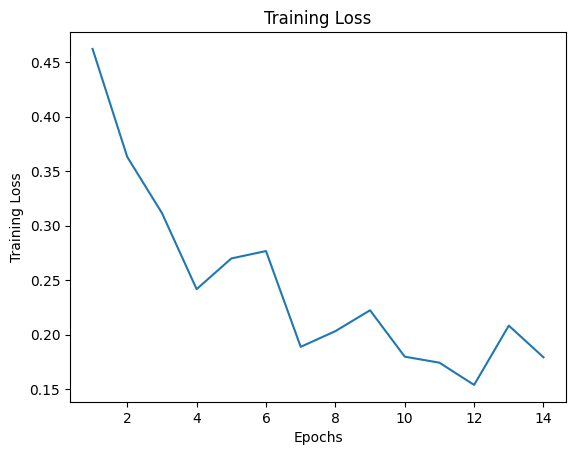

In [109]:
plot_func(train_loss,"Training Loss",Epoch-1)

## Plot Test Loss

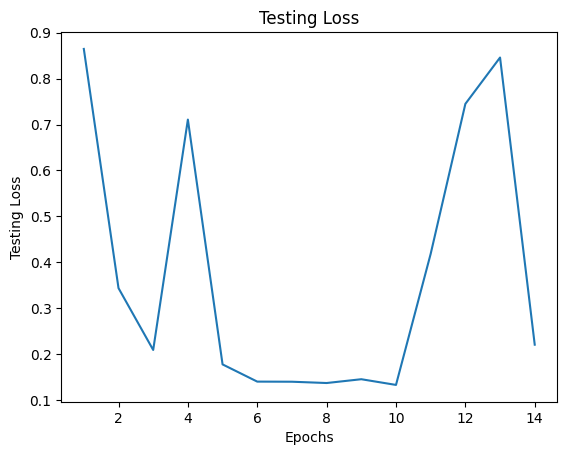

In [110]:
plot_func(test_loss,"Testing Loss",Epoch-1)

# Plot IOU Metric

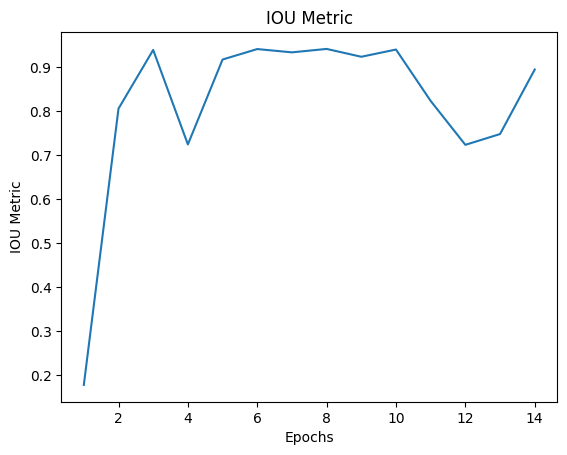

In [111]:
plot_func(iou_param,"IOU Metric",Epoch-1)

## Plot Segment for our mask

In [150]:
temp_itr = iter(val_dataloader)
data,target = temp_itr.next()
with torch.no_grad():
    outputs = model(data.float())
true_out=target
pred_out=225*(outputs>=0.5)


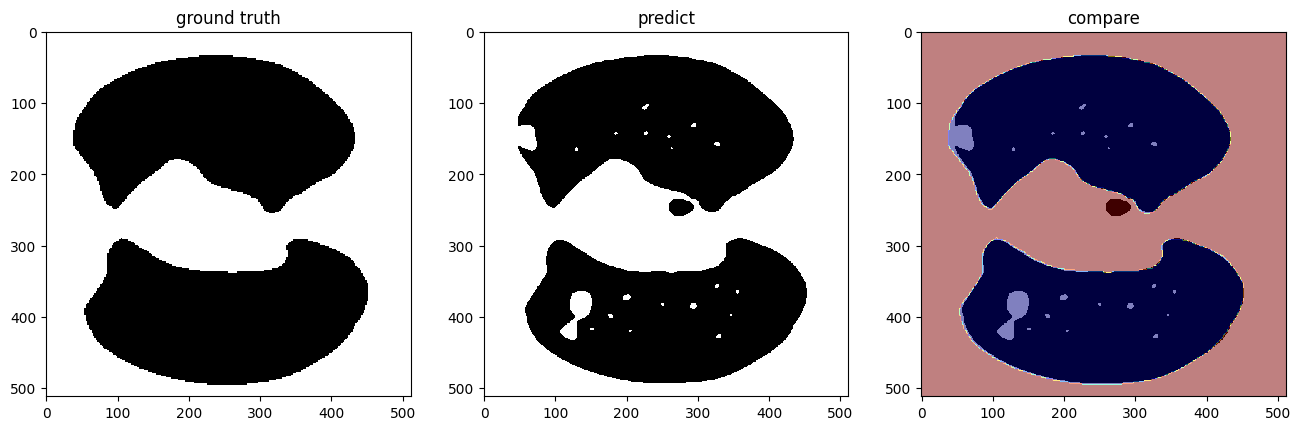

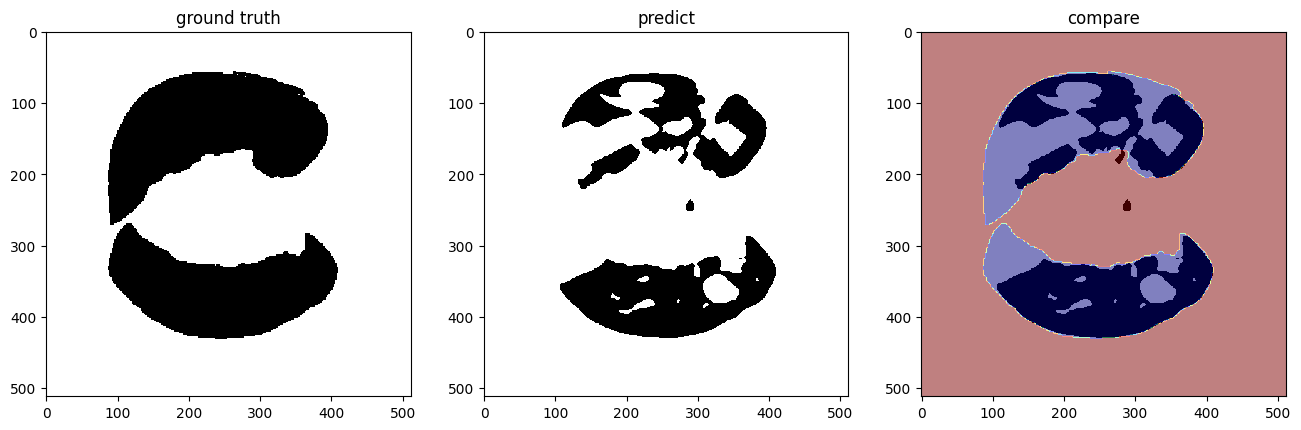

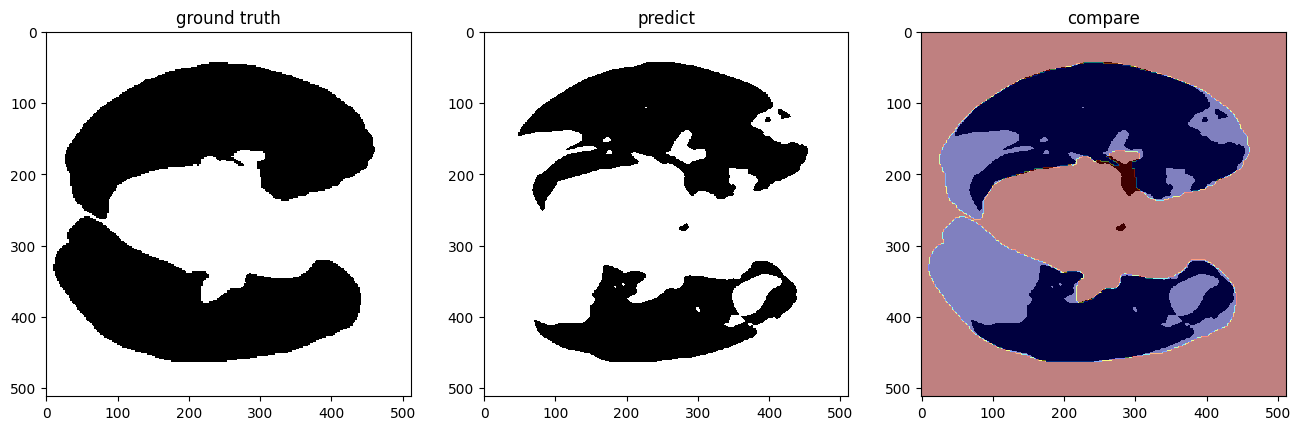

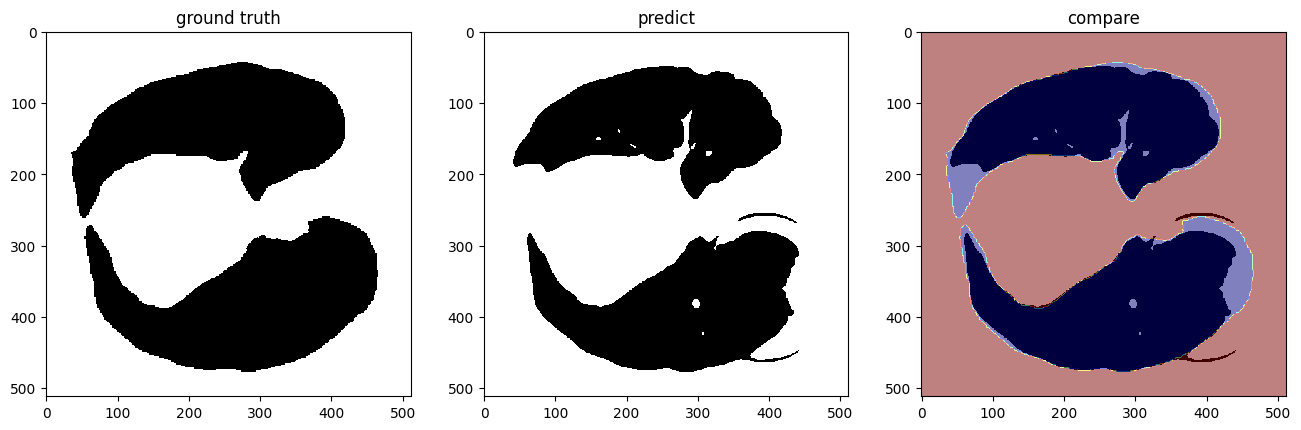

In [164]:

for i in range(4):
    plt.figure(figsize=(16, 8))
    mask = true_out[i].numpy()[0]
    pred = pred_out[i].numpy()[0]
    plt.subplot(1,3,1)
    plt.imshow(mask, 'gray', interpolation='none')
    plt.title("ground truth")
    plt.subplot(1,3,2)
    plt.imshow(pred, 'gray', interpolation='none')
    plt.title("predict")
    plt.subplot(1,3,3)
    plt.imshow(pred, 'gray', interpolation='none')
    plt.imshow(mask, cmap='jet', alpha=0.5) 
    plt.title("compare")
    plt.show()

## Segment Output for Ground Glass

In [165]:
Ground_Class_dataset = Dataset(imgs.reshape((100,1,512,512)), msks[:,:,:,0].reshape((100,1,512,512)))

In [166]:
# 0.1 for test
from torch.utils.data import random_split
tst_size = int(np.ceil(dataset.__len__()*0.1))
train_size = dataset.__len__()- tst_size 
G_train_data,G_test_data = random_split(Ground_Class_dataset,[train_size,tst_size])

In [167]:
# batchsize < 5
from torch.utils.data import DataLoader,TensorDataset
batch_size=4
G_train_dataloader = DataLoader(G_train_data,batch_size = batch_size,shuffle=True)
G_val_dataloader = DataLoader(G_test_data,batch_size = batch_size,shuffle=True)

In [168]:
temp_itr = iter(G_val_dataloader)
data,target = temp_itr.next()
with torch.no_grad():
    outputs = model(data.float())
true_out=target
pred_out=225*(outputs>=0.5)


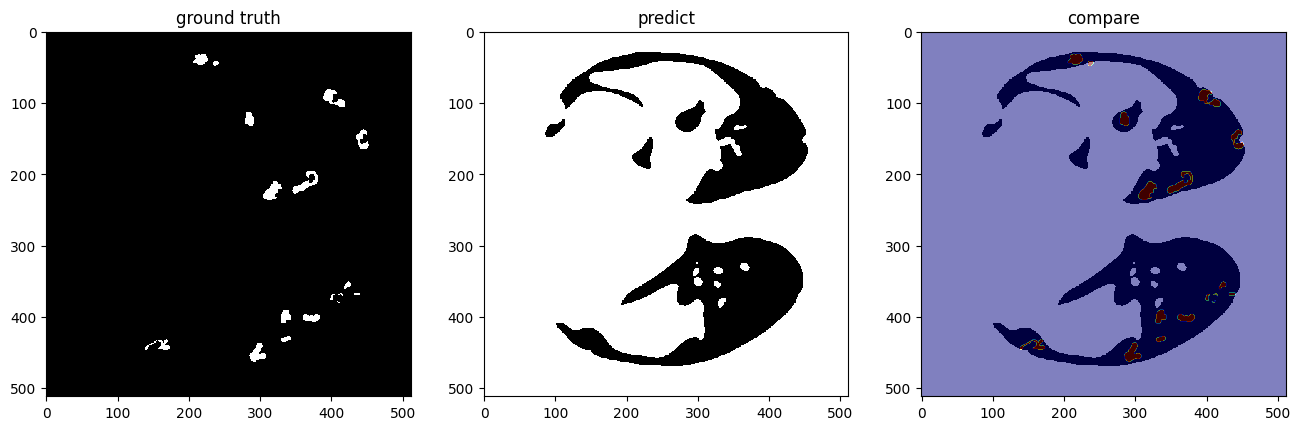

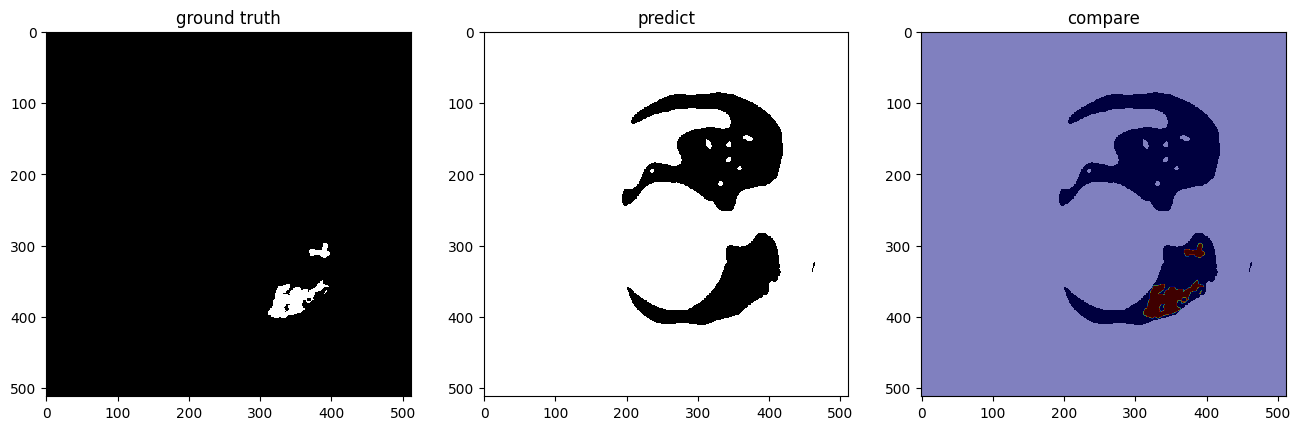

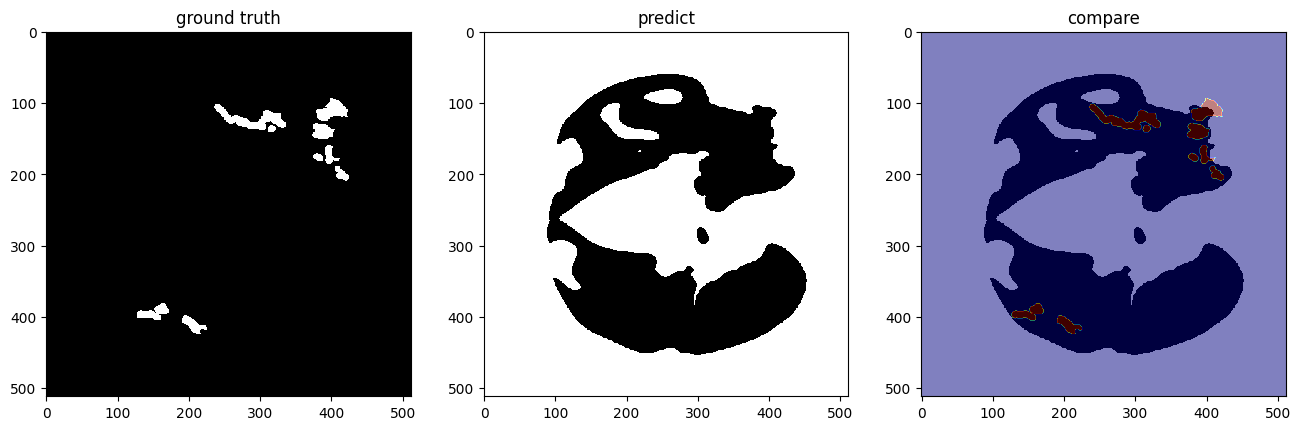

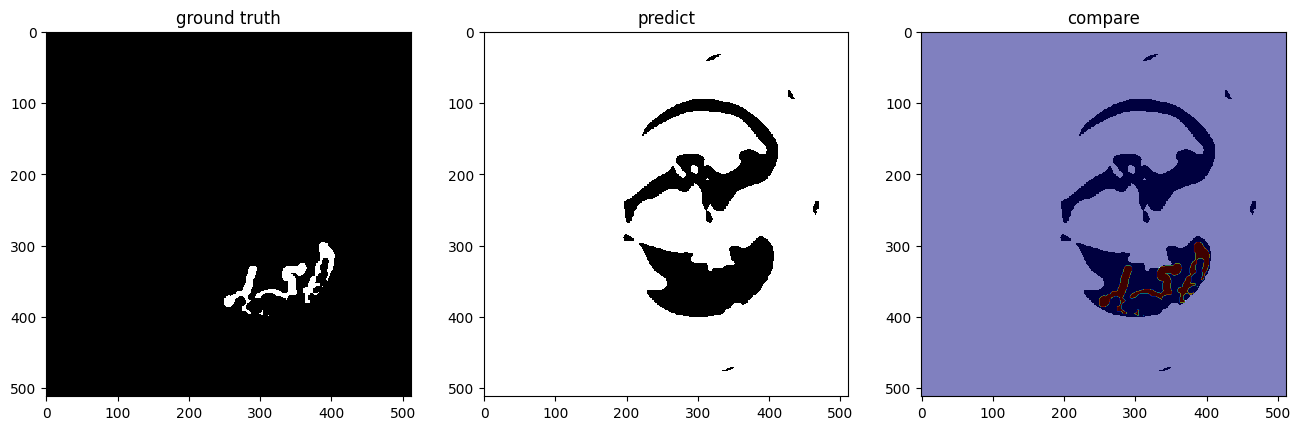

In [169]:
for i in range(4):
    plt.figure(figsize=(16, 8))
    mask = true_out[i].numpy()[0]
    pred = pred_out[i].numpy()[0]
    plt.subplot(1,3,1)
    plt.imshow(mask, 'gray', interpolation='none')
    plt.title("ground truth")
    plt.subplot(1,3,2)
    plt.imshow(pred, 'gray', interpolation='none')
    plt.title("predict")
    plt.subplot(1,3,3)
    plt.imshow(pred, 'gray', interpolation='none')
    plt.imshow(mask, cmap='jet', alpha=0.5) 
    plt.title("compare")
    plt.show()

## Improve U-Net (bonus)


### Define Another Loss function Based On IOU Parameters

 <div dir="rtl">
بر اساس این رویکرد ما علاوه بر تایع هزینه کراس آنتورپی یک تابع هزینه ی دیگر نیز تعریف می کنیم که به نوعی خود معیار  IOU را نیز در محاسابات تابع هزینه دخیل می کند
</dir>

In [209]:
class Loss_iou_based(nn.Module):
    def __init__(self):
        super(Loss_iou_based,self).__init__()
    def forward(self,output,target):
        treshhold=0.5
        smooth_param = 1e-7
        oss = output > treshhold
        tss = target > treshhold
        inter = (oss & tss).sum(axis=[1, 2, 3])
        U = (oss | tss).sum(axis=[1, 2, 3])
        iou = ((inter + smooth_param) / (U + smooth_param)).mean()
        out = 10 * (1- iou)
        return out


In [210]:
class Up(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Up, self).__init__()
        ###########################################
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv_layers= nn.Sequential(
            Conv2d(
                  channel_in,
                   channel_out,
                   kernel_size=3,
                   padding=1),
                   nn.BatchNorm2d(channel_out),
                   nn.ReLU(),
            Conv2d(
                  channel_out,
                   channel_out,
                   kernel_size=3,
                   padding=1),
                   nn.BatchNorm2d(channel_out),
                   nn.ReLU()
        )
        ###########################################

    def forward(self, output1, output2):
        ###########################################
        output1 = self.upsample(output1)
        X_minus = output1.size()[2] - output2.size()[2]
        Y_minus = output1.size()[3] - output2.size()[3]
        output2 = F.pad(output2, (X_minus // 2, int(X_minus / 2),
                        Y_minus // 2, int(Y_minus / 2)))
        final_output = torch.cat([output2, output1], dim=1)
        final_output = self.conv_layers(final_output)
        return final_output        
        ###########################################
        
class Down(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Down, self).__init__()
        ###########################################
        self.conv_layers = nn.Sequential(
            Conv2d(
                channel_in,
                channel_out,
                kernel_size = 3,
                padding = 1),
                nn.BatchNorm2d(channel_out),
                nn.ReLU(),
            Conv2d(
                channel_out,
                channel_out,
                kernel_size = 3,
                padding = 1),
                nn.BatchNorm2d(channel_out),
                nn.ReLU()
        )
        ###########################################

    def forward(self, x):
        ###########################################
        x = self.conv_layers(F.max_pool2d(x,2))
        return x
        ###########################################

class UNet_imporoved(nn.Module):
    def __init__(self, channel_in, classes):
        super(UNet_imporoved, self).__init__()
        ###########################################
        self.conv1 = nn.Sequential(
            Conv2d(channel_in, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.down1 = Down(8, 16)
        self.down2 = Down(16, 32)
        self.down3 = Down(32, 32)
        self.up1 = Up(64, 16)
        self.up2 = Up(32, 8)
        self.up3 = Up(16, 4)
        self.conv2 = nn.Conv2d(4, classes, kernel_size = 1)
        ###########################################


    def forward(self, x):
        ###########################################
        output1 = self.conv1(x)
        output2 = self.down1(output1)
        x3 = self.down2(output2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, output2)
        x = self.up3(x, output1)
        x = self.conv2(x)
        x = F.sigmoid(x)
        return x
        ###########################################

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_uniform(m.weight, gain=numpy.sqrt(2.0))
        init.constant(m.bias, 0.1)

In [211]:
treshhold=0.5
smooth_param = 1e-7
def IoU(output, target):
    oss = output > treshhold
    tss = target > treshhold
    inter = (oss & tss).sum(axis=[1, 2, 3])
    U = (oss | tss).sum(axis=[1, 2, 3])
    iou = ((inter + smooth_param) / (U + smooth_param)).mean()
    return iou

In [212]:
model = UNet_imporoved(1, 1)
model.to(dev)
model

UNet_imporoved(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (down1): Down(
    (conv_layers): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down2): Down(
    (conv_layers): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, mo

In [213]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.BCELoss()
iou_loss=Loss_iou_based()

In [214]:
def train(model, epoch):
    print ("***************Epoch Number "+str(epoch)+" is started***************")
    model.train()
    tr_loss=0.0
    correct = 0
    temp=0
    for data,target in train_dataloader:
        data, target = data.to(dev),target.to(dev)
        target = (target-torch.min(target))/(torch.max(target)-torch.min(target))
        optimizer.zero_grad()
        output = model.forward(data.float())
        loss = criterion(output.float(), target.float())+iou_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("Epoch Number {"+str(epoch)+"}:")
        print("Loss: "+str(float(loss.data)))
        tr_loss=tr_loss+float(loss.data)
        temp=temp+1
    train_loss.append(tr_loss/temp)      
            
            

def test(model):
    model.eval()
    loss = iou = 0.
    for data,target in val_dataloader:
        data, target = data.to(dev),target.to(dev)
        output = model(data.float())
        target = (target-torch.min(target))/(torch.max(target)-torch.min(target))
        loss +=((criterion(output.float(), target.float()).data )+iou_loss(output, target))
        iou += IoU(output, target)   
    loss /= len(val_dataloader)
    test_loss.append(float(loss))
    iou /= len(val_dataloader)
    iou_param.append(float(iou))
    print("Test Loss:")
    print(float(loss))
    print("IOU metric:")
    print(float(iou))
    
def plot_func(loss,status,epch):
        plt.style.use("default")
        plt.title(status)
        plt.plot(range(1, epch+1), loss)
        plt.ylabel(status)
        plt.xlabel('Epochs')
        plt.show()


In [215]:
train_loss=[]
test_loss=[]
iou_param=[]
Epoch = 15

for i in range(1, Epoch):
    train(model, i)
    test(model)

***************Epoch Number 1 is started***************
Epoch Number {1}:
Loss: 3.0330729484558105
Epoch Number {1}:
Loss: 3.757601499557495
Epoch Number {1}:
Loss: 3.205662488937378
Epoch Number {1}:
Loss: 2.635540008544922
Epoch Number {1}:
Loss: 3.5152366161346436
Epoch Number {1}:
Loss: 2.724210500717163
Epoch Number {1}:
Loss: 2.97617506980896
Epoch Number {1}:
Loss: 4.9112348556518555
Epoch Number {1}:
Loss: 2.807501792907715
Epoch Number {1}:
Loss: 3.244290828704834
Epoch Number {1}:
Loss: 2.911402702331543
Epoch Number {1}:
Loss: 3.5921356678009033
Epoch Number {1}:
Loss: 2.749905586242676
Epoch Number {1}:
Loss: 3.093005418777466
Epoch Number {1}:
Loss: 2.4732778072357178
Epoch Number {1}:
Loss: 3.083512783050537
Epoch Number {1}:
Loss: 3.960113048553467
Epoch Number {1}:
Loss: 2.209848165512085
Epoch Number {1}:
Loss: 2.777078866958618
Epoch Number {1}:
Loss: 2.476274251937866
Epoch Number {1}:
Loss: 3.9152166843414307
Epoch Number {1}:
Loss: 4.06551456451416
Epoch Number {1}

Epoch Number {8}:
Loss: 1.0328383445739746
Epoch Number {8}:
Loss: 2.352529764175415
Epoch Number {8}:
Loss: 1.079358696937561
Epoch Number {8}:
Loss: 1.3311892747879028
Epoch Number {8}:
Loss: 2.0145974159240723
Epoch Number {8}:
Loss: 0.39865896105766296
Epoch Number {8}:
Loss: 0.9495713114738464
Epoch Number {8}:
Loss: 0.46185770630836487
Epoch Number {8}:
Loss: 0.6310685873031616
Epoch Number {8}:
Loss: 0.6968713998794556
Epoch Number {8}:
Loss: 2.8092567920684814
Epoch Number {8}:
Loss: 1.8395700454711914
Test Loss:
1.3040941953659058
IOU metric:
0.8944602012634277
***************Epoch Number 9 is started***************
Epoch Number {9}:
Loss: 0.5676970481872559
Epoch Number {9}:
Loss: 1.5162663459777832
Epoch Number {9}:
Loss: 1.0778738260269165
Epoch Number {9}:
Loss: 0.39583027362823486
Epoch Number {9}:
Loss: 0.7883025407791138
Epoch Number {9}:
Loss: 1.382475733757019
Epoch Number {9}:
Loss: 1.0894594192504883
Epoch Number {9}:
Loss: 1.7160398960113525
Epoch Number {9}:
Loss:

## Based on our approach we had increade iou metric from 89% to 92%